In [16]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import os

np.random.seed(2)
torch.manual_seed(2)

# Define Transformer
def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

class T(nn.Module):
    def __init__(self,w=256):
        super(T, self).__init__()
        self.l1 = nn.Linear(2,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,2)
    
    def forward(self, x, eps=1.0):
        bs = x.shape[0]
        #f = nn.ReLU()
        #f = nn.Tanh()
        f = nn.SiLU()
        # make it equivariant
        t = x[:,0]
        x1 = x[:,1]
        x2 = x[:,2]
        x3 = x[:,3]
        r = torch.sqrt(x1**2+x2**2+x3**2)
        self.tr = torch.transpose(torch.stack([t, r]),0,1)
        out = f(self.l1(self.tr))
        out = f(self.l2(out))
        out = self.l3(out)
        nn_out = torch.empty((x.shape[0], 4), requires_grad=False)
        nn_out[:,0] = out[:,0]
        nn_out[:,1] = out[:,1]*x1
        nn_out[:,2] = out[:,1]*x2
        nn_out[:,3] = out[:,1]*x3
        return x + eps*nn_out
        '''nn_out[:,0] = t*torch.sqrt(1+r**2)
        nn_out[:,1] = t*x1
        nn_out[:,2] = t*x2
        nn_out[:,3] = t*x3
        return nn_out'''
        
    
    def transform_g(self, x):
        jac_ts = batch_jacobian(self.forward, x, create_graph=True)
        jac_inv_ts = torch.inverse(jac_ts)
        return torch.matmul(torch.matmul(jac_inv_ts.permute(0,2,1), g(x)),jac_inv_ts)

In [17]:
def Minkowski_loss(g,t,inputs):
    gp = t.transform_g(inputs)
    bs = gp.shape[0]
    minkowski_metric = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=2) * torch.unsqueeze(torch.diag(torch.tensor([1.,-1.,-1.,-1.], dtype=torch.float, requires_grad=True)), dim=0)
    return torch.mean((gp-minkowski_metric)**2)

In [34]:
from celluloid import Camera
fig = plt.figure(figsize=(15,5))
camera = Camera(fig)


# Training a transformer to minimize PDE losses
k = -1
noise = 3e-3


def g(x_):
    bs = x_.shape[0]
    t = x_[:,0]
    a = t
    x = x_[:,1]
    y = x_[:,2]
    z = x_[:,3]
    r = torch.sqrt(x**2+y**2+z**2)
    stack1 = torch.stack([torch.ones(bs,), torch.zeros(bs,), torch.zeros(bs,), torch.zeros(bs,)])
    stack2 = torch.stack([torch.zeros(bs,), -a**2/r**2*(x**2/(1-k*r**2)+y**2+z**2), -a**2*k*x*y/(1-k*r**2), -a**2*k*x*z/(1-k*r**2)])
    stack3 = torch.stack([torch.zeros(bs,), -a**2*k*x*y/(1-k*r**2), -a**2/r**2*(y**2/(1-k*r**2)+x**2+z**2), -a**2*k*y*z/(1-k*r**2)])
    stack4 = torch.stack([torch.zeros(bs,), -a**2*k*x*z/(1-k*r**2), -a**2*k*y*z/(1-k*r**2), -a**2/r**2*(z**2/(1-k*r**2)+x**2+y**2)])
    gs = torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
    gs = gs + torch.normal(0,1,size=(bs,4,4))*noise
    return gs

        
#W = torch.rand(1000,4, requires_grad=True)
W = torch.normal(0,1,size=(1000,4),requires_grad=True)
#input_ = W
input_ = torch.empty(1000,4, requires_grad=False)
input_[:,0] = torch.rand(1000, requires_grad=True) + 1.0
input_[:,1] = torch.rand(1000, requires_grad=True)*2.0-1.0
input_[:,2] = torch.rand(1000, requires_grad=True)*2.0-1.0
input_[:,3] = torch.rand(1000, requires_grad=True)*2.0-1.0
#input_[:,1:] = torch.abs(torch.rand(1000, requires_grad=True))
#input_[:,1:] = W[:,1:]


input_d = input_.shape[1]


t = T(w=400)
epochs = 5000
lr_decay_epoch = 1000

n_train = input_.shape[0]
batch_size = 128

lr = 1e-3
optimizer = optim.Adam(t.parameters(), lr=lr)
#optimizer = optim.SGD(t.parameters(), lr=lr, momentum=0.95)

log = 50

losses = []

for epoch in range(epochs):

    t.train()
    optimizer.zero_grad()

    choices = np.random.choice(n_train, batch_size, replace=False)
    inputs = input_[choices]
    
    if (epoch+1) % lr_decay_epoch == 0:
        for opt_param in optimizer.param_groups:
            lr = lr * 0.5
            opt_param['lr'] = lr

    loss = Minkowski_loss(g,t,inputs)

    losses.append(loss.detach().numpy())
    #loss.backward(retain_graph=True)
    loss.backward(retain_graph=True)
    optimizer.step()


    if epoch%log == 0:
        print('Epoch:  %d | Minkowski_loss: %.8f ' %(epoch, loss))


Epoch:  0 | Minkowski_loss: 0.71985662 
Epoch:  50 | Minkowski_loss: 0.12604791 
Epoch:  100 | Minkowski_loss: 0.00481613 
Epoch:  150 | Minkowski_loss: 0.00085472 
Epoch:  200 | Minkowski_loss: 0.00029774 
Epoch:  250 | Minkowski_loss: 0.00014947 
Epoch:  300 | Minkowski_loss: 0.00097238 
Epoch:  350 | Minkowski_loss: 0.00013878 
Epoch:  400 | Minkowski_loss: 0.00008286 
Epoch:  450 | Minkowski_loss: 0.00012898 
Epoch:  500 | Minkowski_loss: 0.00005272 
Epoch:  550 | Minkowski_loss: 0.00016387 
Epoch:  600 | Minkowski_loss: 0.00006567 
Epoch:  650 | Minkowski_loss: 0.00010163 
Epoch:  700 | Minkowski_loss: 0.00006106 
Epoch:  750 | Minkowski_loss: 0.00019857 
Epoch:  800 | Minkowski_loss: 0.00008620 
Epoch:  850 | Minkowski_loss: 0.00011528 
Epoch:  900 | Minkowski_loss: 0.00046429 
Epoch:  950 | Minkowski_loss: 0.00022691 
Epoch:  1000 | Minkowski_loss: 0.00005946 
Epoch:  1050 | Minkowski_loss: 0.00005381 
Epoch:  1100 | Minkowski_loss: 0.00004603 
Epoch:  1150 | Minkowski_loss: 0.0

<Figure size 1080x360 with 0 Axes>

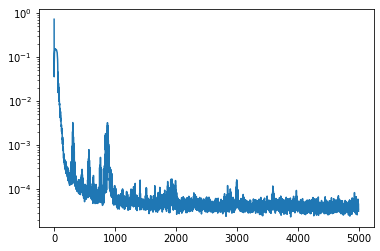

In [36]:
plt.plot(np.arange(epochs), losses[:epochs])
plt.yscale('log')

In [37]:
np.save('./results/frw_m1_0d003.npy', losses)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

frw_m1 = np.load('./results/frw_m1.npy')
frw_0d01 = np.load('./results/frw_m1_0d01.npy')
frw_0d03 = np.load('./results/frw_m1_0d03.npy')
frw_0d001 = np.load('./results/frw_m1_0d001.npy')
frw_0d003 = np.load('./results/frw_m1_0d003.npy')
frw_0d1 = np.load('./results/frw_m1_0d1.npy')
frw_0d3 = np.load('./results/frw_m1_0d3.npy')
#frw_1 = np.load('./results/frw_1.npy')

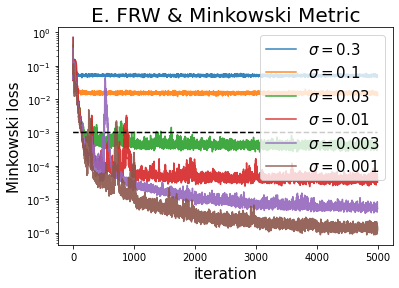

In [6]:
alpha = 0.9
plt.plot(frw_0d3, alpha=alpha)
plt.plot(frw_0d1, alpha=alpha)
plt.plot(frw_0d01, alpha=alpha)
plt.plot(frw_0d003, alpha=alpha)
plt.plot(frw_0d001, alpha=alpha)
plt.plot(frw_m1, alpha=alpha)

epochs = 5000

plt.xlabel('iteration',fontsize=15)
plt.ylabel('Minkowski loss',fontsize=15)
plt.legend([r"$\sigma=0.3$",r"$\sigma=0.1$",r"$\sigma=0.03$",r"$\sigma=0.01$",r"$\sigma=0.003$",r"$\sigma=0.001$",r"$\sigma=0$"], fontsize=15)

plt.plot(np.arange(epochs), np.ones(epochs,)*1e-3, ls="--", color="black")
#plt.arrow(1500,0.01,0,-0.005,head_width=50,head_length=0.001,linewidth=3, color="blue")
#plt.text(1000,0.015,"Minkowski Loss",fontsize=15,color="blue")
plt.title('E. FRW & Minkowski Metric',fontsize=20)
plt.yscale('log')
plt.savefig('./figures/frw_noise.png', bbox_inches="tight")